# **Thermal Waves Experiment**
This jupyter notebook contains the data analysis for the thermal waves section of the script. It contains tasks 1.5 to 1.7.


In [682]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from data_utils import load_dataset, truncate_transient
import re
import os
from IPython.display import Math, display

## **Plane Slab Model of the Cylinder**

The flow of heat in a medium is described by the **heat equation**, which for a plane slab (1-D system) is:

$$
\frac{\partial T(x,t)}{\partial t} = D \frac{\partial^2 T(x,t)}{\partial x^2}
$$

where $T(x,t)$ is the temperature in the medium as a function of space and time, and $D$ is the **thermal diffusivity** of the medium.

Equation (1.1) is a **diffusion equation**, which is a *linear differential equation* like Schrödinger’s equation and the wave equation in the *Electrical Waves* experiment.

---

### Analytical Solution

A solution for $T(x,t)$ that decays in space and oscillates in time with angular frequency $\omega$ is:

$$
T(x,t) = T_0 + C e^{-\sqrt{\frac{\omega}{2D}}\,x}
\sin\!\left(\sqrt{\frac{\omega}{2D}}\,x - \omega t + \phi_0 \right)
$$

where $T_0$, $C$, and $\phi_0$ are constants determined by initial and boundary conditions.

---

### Geometry of the Experiment

In the plane slab model, the brass cylinder is treated as a **1-dimensional slab** of thickness

$$
x_i = i\,\Delta d
$$

with the x-axis along the cylinder’s axis.  

Thermal waves propagate along the x-axis, and the thermistor sensors are placed every $\Delta d = 5~\text{mm}$.

We define $x = 0$ at the first thermistor.


In [683]:
delta_d = 5  # 5 mm spacing between thermistors

## **Task 1.5**

**a)** Write a Python script to extract the phase and amplitude of a single thermistor’s readings. Use this to determine the phase difference and attenuation between the $i = 0$ and $i = 3$ thermistors. Does it agree with your rough estimate from Task 1.4?

---

**b)** Repeat this for all thermistors and plot the attenuation factor against distance.

---

**c)** Find a theoretical form for this function using the plane wave model and fit it to your data to extract the thermal diffusivity, $D$.

---

**d)** Do the same for the phase lag, $\Delta \phi_i$.


#### **Task 1.5 (a) – Extract phase and amplitude from thermistors 0 and 3**
We will load up the $i = 0$ and $i = 3$ data and plot both to inspect form:

In [684]:
save_dir = "mock_data"  # The folder that contains the data
files = ['thermal_mock_T10s_run1.csv', 'thermal_mock_T10s_run2.csv', 'thermal_mock_T10s_run3.csv',
         'thermal_mock_T15s_run1.csv', 'thermal_mock_T15s_run2.csv', 'thermal_mock_T15s_run3.csv', 
         'thermal_mock_T20s_run1.csv', 'thermal_mock_T20s_run2.csv', 'thermal_mock_T20s_run3.csv', 
         'thermal_mock_T30s_run1.csv', 'thermal_mock_T30s_run2.csv', 'thermal_mock_T30s_run3.csv', 
         'thermal_mock_T60s_run1.csv', 'thermal_mock_T60s_run2.csv', 'thermal_mock_T60s_run3.csv']

In [685]:

path = os.path.join(save_dir, files[0])
timestamp, V, I, Temperatures, comments = load_dataset(path)

print(comments)
print(Temperatures.shape)

Period = 10.0
(6000, 8)


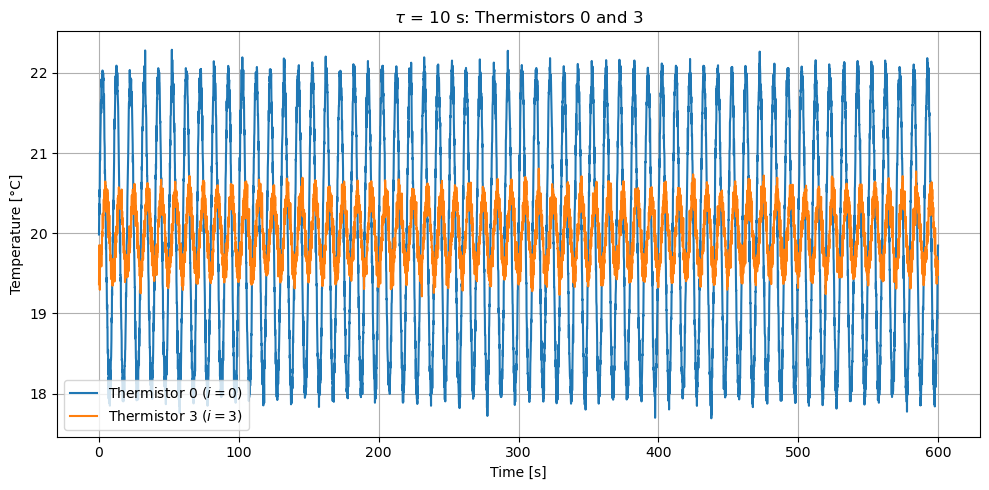

In [686]:
plt.figure(figsize=(10, 5))
plt.plot(timestamp, Temperatures[:, 0], label=r"Thermistor 0 ($i = 0$)")
plt.plot(timestamp, Temperatures[:, 3], label=r"Thermistor 3 ($i = 3$)")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.title(r"$\tau$ = 10 s: Thermistors 0 and 3")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We will now define functions to extract the amplitude and phase from a single thermistor:

In [687]:
def plane_wave_model(t, T0, A, phi, omega):
    return T0 + A * np.sin(omega * t + phi)

def planewave_curvefit(t, y, omega=None, comments=None):
    
    # Function will detect the time period from the comments
    if comments is not None and omega is None:
        T_match = re.search(r"Period\s*=\s*([\d.]+)", comments)
        if not T_match:
            raise ValueError("Couldn't find time period in comments.")
        T = float(T_match.group(1))
        omega = 2 * np.pi / T
 
    # Initial guesses
    T0_guess  = np.mean(y)
    A_guess   = 0.5 * (np.percentile(y,95) - np.percentile(y,5))
    phi_guess = 0.0

    popt, pcov = curve_fit(
        lambda tt, T0, A, phi: plane_wave_model(tt, T0, A, phi, omega),
        t, y,
        p0=[T0_guess, A_guess, phi_guess],
        maxfev=10000
    )
    
    T0, A, phi = popt
    unc_T0, unc_A, unc_phi = np.sqrt(np.diag(pcov))

    # Enforce A ≥ 0
    if A < 0:
        A = -A
        phi = phi + np.pi

    return (T0, unc_T0), (A, unc_A), (phi, unc_phi), omega

In [688]:
(T0_0, unc_T0_0), (A0, unc_A0), (phi0, unc_phi0), omega = planewave_curvefit(timestamp, Temperatures[:,0], comments=comments)

(T0_3, unc_T0_3), (A3, unc_A3), (phi3, unc_phi3), omega = planewave_curvefit(timestamp, Temperatures[:,3], comments=comments)
print()

display(Math(rf"A_0 = {A0:.4f} \pm {unc_A0:.4f}\ \text{{°C}}"))
display(Math(rf"\phi_0 = {phi0:.4f} \pm {unc_phi0:.4f}\ \text{{rad}}"))
display(Math(""))
display(Math(rf"A_3 = {A3:.4f} \pm {unc_A3:.4f}\ \text{{°C}}"))
display(Math(rf"\phi_3 = {phi3:.4f} \pm {unc_phi3:.4f}\ \text{{rad}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

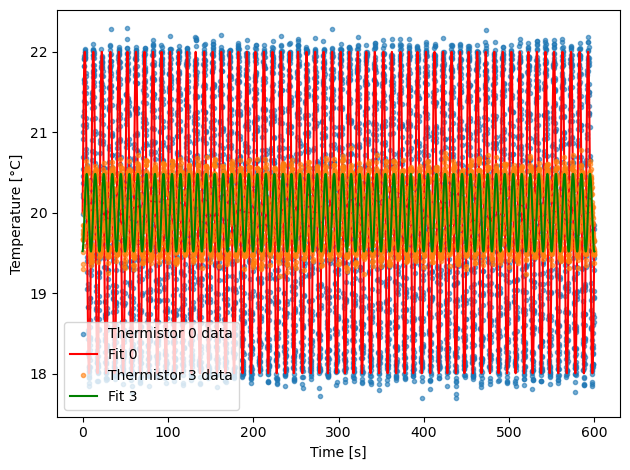

In [689]:
plt.plot(timestamp, Temperatures[:,0], '.', label='Thermistor 0 data', alpha=0.6)
plt.plot(timestamp, plane_wave_model(timestamp, T0_0, A0, phi0, omega), 'r-', label='Fit 0')

plt.plot(timestamp, Temperatures[:,3], '.', label='Thermistor 3 data', alpha=0.6)
plt.plot(timestamp, plane_wave_model(timestamp, T0_3, A3, phi3, omega), 'g-', label='Fit 3')

plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.tight_layout()
plt.show()

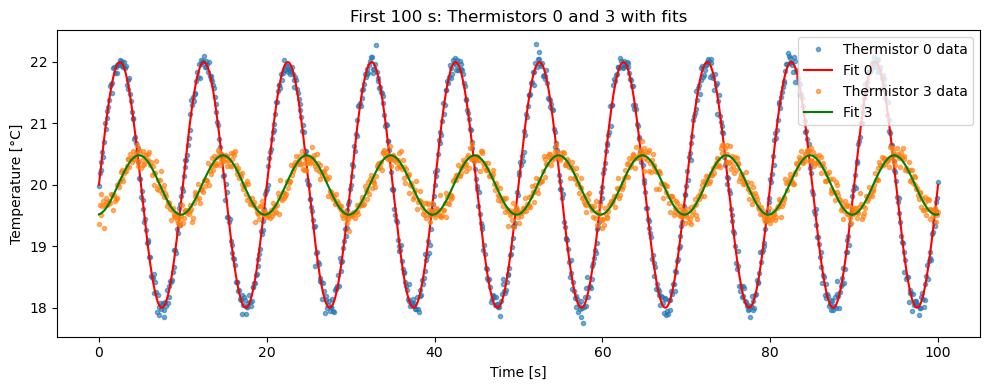

In [690]:
# Mask for first 100 seconds
mask_100 = timestamp <= 100

t_100   = timestamp[mask_100]
T0_100  = Temperatures[mask_100, 0]  # thermistor 0
T3_100  = Temperatures[mask_100, 3]  # thermistor 3

plt.figure(figsize=(10, 4))

plt.plot(t_100, T0_100, '.', label='Thermistor 0 data', alpha=0.6)
plt.plot(t_100, plane_wave_model(t_100, T0_0, A0, phi0, omega),
         'r-', label='Fit 0')

plt.plot(t_100, T3_100, '.', label='Thermistor 3 data', alpha=0.6)
plt.plot(t_100, plane_wave_model(t_100, T0_3, A3, phi3, omega),
         'g-', label='Fit 3')

plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('First 100 s: Thermistors 0 and 3 with fits')
plt.legend()
plt.tight_layout()
plt.show()


Define functions to determine attenuation factor and phase difference:

In [691]:
def attenuation_factor(A1, unc_A1, A2, unc_A2):
    g = A2 / A1
    unc_g = g * np.sqrt((unc_A2/A2)**2 + (unc_A1/A1)**2)
    return g, unc_g

def phase_difference(phi1, unc_phi1, phi2, unc_phi2):
    dphi = phi2 - phi1
    unc_dphi = np.sqrt(unc_phi1**2 + unc_phi2**2)
    return dphi, unc_dphi

In [692]:
g, unc_g = attenuation_factor(A0, unc_A0, A3, unc_A3)
dphi, unc_dphi = phase_difference(phi0, unc_phi0, phi3, unc_phi3)

display(Math(rf"\gamma_3 = {g:.4f} \pm {unc_g:.4f}\ \text{{°C}}"))
display(Math(rf"\Delta\phi_3 = {dphi:.4f} \pm {unc_dphi:.4f}\ \text{{rad}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### **Task 1.5 (b) – Extract transmission factor for all thermistors and plot them**
We now fit **all thermistors** with the same sinusoidal model to extract their
amplitudes $A_i$ and phases $\phi_i$, then compute the attenuation factor
$\gamma_i = A_i / A_0$ and plot it against distance $x_i = i \Delta d$.

In [693]:
n_therm = Temperatures.shape[1]

amps = np.zeros(n_therm)
unc_amps = np.zeros(n_therm)
phases = np.zeros(n_therm)
unc_phases = np.zeros(n_therm)

for i in range(n_therm):
    # Truncate data to remove transients for each thermistor
    t_trunc, T_trunc = truncate_transient(timestamp, Temperatures[:, i], verbose=False)

    (_, _), (A, unc_A), (phi, unc_phi), omega = planewave_curvefit(
        t_trunc, T_trunc,
        comments=comments      # auto-detect the period
    )


    amps[i] = A
    unc_amps[i] = unc_A
    phases[i] = phi
    unc_phases[i] = unc_phi

phases = np.unwrap(phases)

print("Amplitudes A_i:", amps)
print()
print("Phases phi_i  :", phases)


Amplitudes A_i: [1.99697587 1.24391577 0.77704444 0.48239628 0.30152908 0.1871486
 0.11479446 0.07235801]

Phases phi_i  : [ 9.58503460e-04 -4.72033044e-01 -9.44594681e-01 -1.42554055e+00
 -1.90304136e+00 -2.36735243e+00 -2.84819737e+00 -3.28436807e+00]


In [694]:
# Thermistor indices and distances
i_vals = np.arange(n_therm)  # i = 0,1,2,...
x = i_vals * delta_d  # delta_d = 5 mm

# Attenuation factors
gamma = amps / amps[0]
unc_gamma = gamma * np.sqrt(
    (unc_amps / amps) ** 2 + (unc_amps[0] / amps[0]) ** 2)

# Taking natural logs ln(γ_i)
ln_gamma = np.log(gamma)
unc_ln_gamma = unc_gamma/gamma

# Compute phase lag relative to thermistor 0
dphi = phases - phases[0]
unc_dphi = np.sqrt(unc_phases**2 + unc_phases[0]**2)


print("Attenuation Factors:", gamma)
print("Phase Lags:", dphi)


Attenuation Factors: [1.         0.62289975 0.38911058 0.2415634  0.15099285 0.09371601
 0.05748415 0.03623379]
Phase Lags: [ 0.         -0.47299155 -0.94555318 -1.42649905 -1.90399987 -2.36831094
 -2.84915587 -3.28532658]


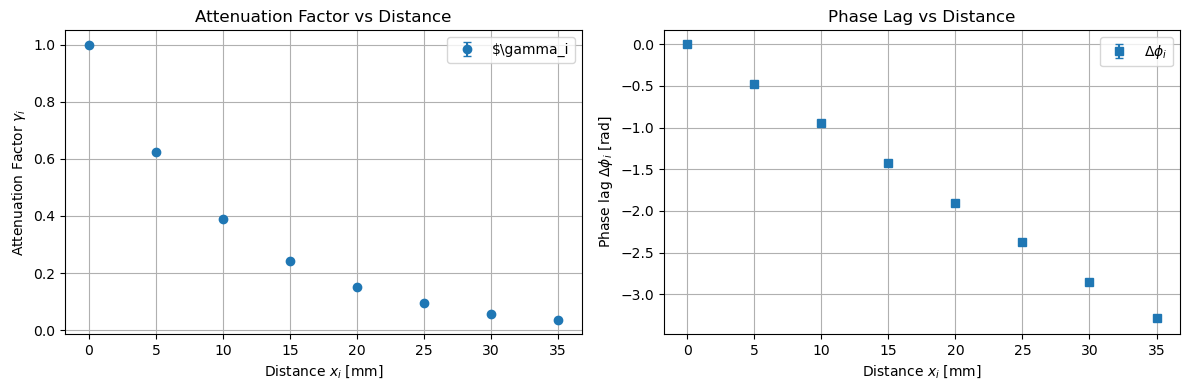

In [695]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Left Plot: Attenuation Factor vs Distance
ax = axes[0]
ax.errorbar(
    x, gamma,
    yerr = unc_gamma,
    fmt = 'o', capsize=3,
    label = r'$\gamma_i')

ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"Attenuation Factor $\gamma_i$")
ax.set_title("Attenuation Factor vs Distance")
ax.grid(True)
ax.legend()

# Right Plot: Phase-lag vs Distance
ax = axes[1]
ax.errorbar(
    x, dphi,
    yerr=unc_dphi,
    fmt='s', capsize=3,
    label=r'$\Delta\phi_i$',)

ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"Phase lag $\Delta\phi_i$ [rad]")
ax.set_title("Phase Lag vs Distance")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


#### **Task 1.5 (c) – Fit attenuation vs distance to extract $D_\gamma$**

From the plane-wave solution, the attenuation factor 

$$
\ln(\gamma_i) = -\sqrt{\frac{\omega}{2D}} \, (i\Delta d)
$$

where $x_i = i \Delta d$, so we fit

$$
\ln(\gamma_i) = k_{\gamma} \, x_i
$$

and compute the diffusivity:

$$
D = \frac{\omega}{2 k_{\gamma}^2}.
$$

---

#### **Task 1.5 (d) – Fit phase lag vs distance to extract $D_\phi$**

The theoretical phase lag is

$$
\Delta\phi_i = \sqrt{\frac{\omega}{2D}} \, (i\Delta d),
$$

where $x_i = i \Delta d$, so we fit

$$
\Delta\phi_i = k_{\phi} \, x_i.
$$

Thus,

$$
D = \frac{\omega}{2 k_{\phi}^2}.
$$


In [696]:
def linear(x, k, c):
    return k * x + c

In [697]:
# Apply linear fit to ln(gamma) vs distance
popt_gamma, pcov_gamma = curve_fit(
    linear,
    x,
    ln_gamma,
    sigma = unc_ln_gamma,
    absolute_sigma = True,
    maxfev=10000
)
k_gamma, c_gamma = popt_gamma
unc_k_gamma, unc_c_gamma = np.sqrt(np.diag(pcov_gamma))

# Diffusivity from transmission factor (mm^2/s)
D_gamma = omega / (2 * k_gamma ** 2)
unc_D_gamma = np.abs(-omega / (k_gamma ** 3)) * unc_k_gamma

# Display results
display(Math(rf"D_\gamma = {D_gamma:.3f} \pm {unc_D_gamma:.3f}\ \text{{mm}}^2/\text{{s}}"))


# Apply linear fit to phase lag vs distance
popt_phi, pcov_phi = curve_fit(
    linear,
    x,
    dphi,
    sigma=unc_dphi,
    absolute_sigma=True,
    maxfev=10000
)
k_phi, c_phi = popt_phi
unc_k_phi, unc_c_phi = np.sqrt(np.diag(pcov_phi))

# Diffusivity from phase (mm^2/s)
D_phi = omega / (2 * k_phi ** 2)
unc_D_phi = np.abs(-omega / (k_phi ** 3)) * unc_k_phi

# Display results
display(Math(rf"D_\phi = {D_phi:.3f} \pm {unc_D_phi:.3f}\ \text{{mm}}^2/ \text{{s}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

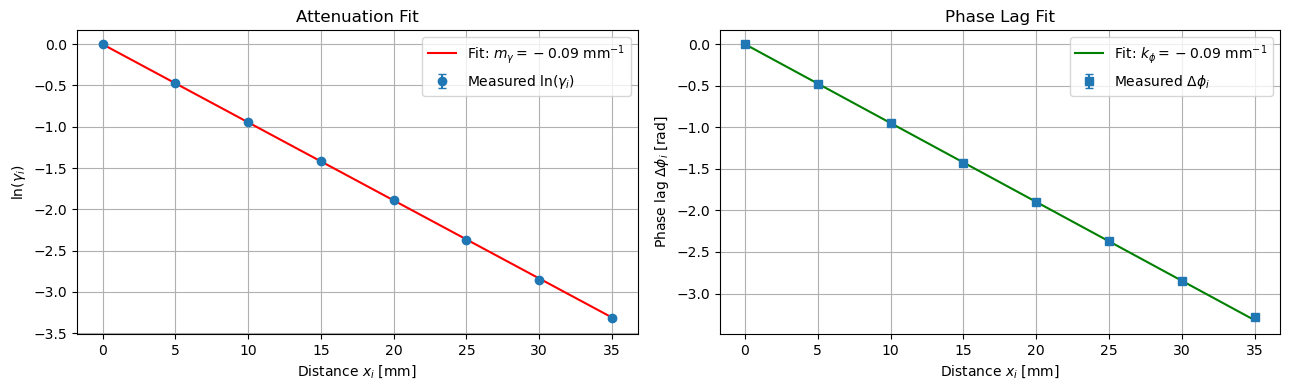

In [698]:
# Plot both fits on with the data

x_dense = np.linspace(x.min(), x.max(), 300)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# ----- Left: Attenuation fit -----
ax = axes[0]
ax.errorbar(
    x, ln_gamma,
    yerr=unc_ln_gamma,
    fmt='o', capsize=3,
    label=r'Measured $\ln(\gamma_i)$'
)
ax.plot(
    x_dense,
    linear(x_dense, k_gamma, c_gamma),
    'r-',
    label=rf'Fit: $m_\gamma = {k_gamma:.2f}$ mm$^{{-1}}$'
)
ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"$\ln(\gamma_i)$")
ax.set_title("Attenuation Fit")
ax.grid(True)
ax.legend()

# Right Plot: Phase-lag fit
ax = axes[1]
ax.errorbar(
    x, dphi,
    yerr = unc_dphi,
    fmt = 's', capsize = 3,
    label = r'Measured $\Delta\phi_i$'
)
ax.plot(
    x_dense,
    linear(x_dense, k_phi, c_phi),
    'g-',
    label=rf'Fit: $k_\phi = {k_phi:.2f}$ mm$^{{-1}}$'
)
ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"Phase lag $\Delta\phi_i$ [rad]")
ax.set_title("Phase Lag Fit")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

## **Task 1.6**

**a)** Send sine wave of different periods, e.g. 15s, 20s, 30s, 60s. Repeat each dataset a few times and use this to estimate the noise level on your extracted phase and amplitudes. Don’t forget to let the temperatures stabilize! 

---

**b)** Plot the attenuation and phase lags for each frequency and extract estimates of D for each frequency with each method. How well does the model work at all these frequencies?


